# 第2回：K-means & 階層的クラスタリング

このHands-onでは下記の4種類のデータを用いて，K-meansと階層的クラスタリングを体験します．
* アヤメの個体データ
* 人工的な2次元データ
* とある購買データ
* 2018年度プロ野球打者成績データ

Hands-onに先立って，必要なライブラリを読み込んでおきます．

In [1]:
# 表形式のデータを操作するためのライブラリ
import pandas as pd

# 行列計算をおこなうためのライブラリ
import numpy as np

# 機械学習用ライブラリsklearnのKmeansクラス
from sklearn.cluster import KMeans

# 距離行列の計算のためのライブラリ
import scipy.spatial.distance as distance

# 階層的クラスタリング用のライブラリ
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

# グラフ描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set(style='ticks')
%matplotlib inline


# 警告文を表示させないおまじない
import warnings
warnings.filterwarnings('ignore')

また，このHands-onでは日本語を含むグラフを生成するため，問題が生じないよう以下のおまじないコードを実行しておいてください．

In [2]:
try:
    import japanize_matplotlib 
except:
    !pip install japanize-matplotlib


---



## 例題1: アヤメデータに対するK-meansクラスタリング

データマイニングや機械学習を学ぶ際，例題データとしてアヤメ（英語名:Iris）データがよく用いられます（[アヤメ](https://ja.wikipedia.org/wiki/%E3%82%A2%E3%83%A4%E3%83%A1)は植物の1つです）．決定木を体験する題材としても利用しました．
このHands-onでもアヤメデータを使ってみましょう．

### データの準備
以下のコードを実行して，アヤメのデータを読み込みましょう．
下記コードを実行すると，変数`iris_df`（pandasデータフレーム）にアヤメのデータが読み込まれます．

In [3]:
from sklearn import datasets

# Iris（アヤメ）の大きさに関するデータをロード
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]

# 簡単のために，カラム名を修正しておく
iris_df = iris_df.rename(
    columns = {
        'sepal length (cm)': 'sepal_length',
        'sepal width (cm)': 'sepal_width',
        'petal length (cm)': 'petal_length',
        'petal width (cm)': 'petal_width'
    }
)

どんなデータが入っているか，iris_dfの中身をのぞいてみましょう．

In [4]:
# ロードしたデータの中身（最初の数件）を確認
iris_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


このデータには，アヤメの「花弁（Petal）」と「がく（Sepal）」の大きさ，長さ，およびアヤメの品種に関する情報が入っています．1行1行がアヤメの個体に対応しています．
格納されているアヤメの種類はsetosa, virginica, versicolorの3種類です．それぞれの品種について，50個ずつデータが入っています．


### データの可視化

このHands-onでは，品種（species）の情報は無視して，花弁とがくの大きさ・長さの4種類の指標に着目します．
つまり**4次元**のデータを扱います．
私たちは普段3次元の世界で生きているので，4次元のデータをイメージすることは難しいです．ですので，まずはデータを2次元にして，データの様子を可視化してみましょう．

アヤメデータから花弁の大きさ，長さのみを取り出して，XY平面に点をプロットしてみましょう．Pandasデータフレームでは，``df.x``とすると表データ``df``の列``x``のデータを抜き出すことができます．点をプロットするには``plt.scatter``関数を用います．

では，下記のコードを実行してみてください．

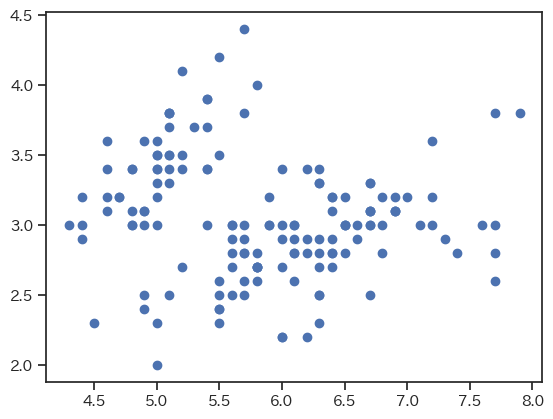

In [5]:
plt.scatter(iris_df.sepal_length, iris_df.sepal_width)

表示されたグラフ（散布図）を眺めてみてください．「データをグルーピングする」という観点で眺めたとき，何か特徴はつかめたでしょうか？心の目で眺めてみると，なんとなくですが，データ点が「左上」と「右下」で分かれているような気もします．

### K-meansの実行

今回のアヤメのデータには3種類の品種が混じっています．もし品種毎に性質がキレイに分かれるとすると，上記の点の集合も3グループに分かれてもよさそうです．ということで，今回はクラスタ数を**3**として，K-meansクラスタリングを実行してみましょう．

アヤメデータを可視化したときは，花弁の長さと大きさの2指標に絞ってデータを眺めました．
今回のK-meansクラスタリングでは，その2指標を特徴とする2次元データに対して分析をしてみましょう．

完全なアヤメデータから「花弁の長さ」と「大きさ」のみに着目してデータを取り出すには以下のようにします．

In [6]:
target_features = ['sepal_length', 'sepal_width']
iris_df[target_features]

,sepal_length,sepal_width
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6
...,...,...
145,6.7,3.0
146,6.3,2.5
147,6.5,3.0
148,6.2,3.4


このデータに対してK-meansを実行してみましょう．

`sklearn`ライブラリで機械学習を行う場合，以下のようなステップを踏みます：
1. 学習モデルのクラスインスタンスを作成
2. データを入力し学習（fitメソッド）
3. 学習済みモデルを用いて，分析結果を得る（transformやpredictメソッド）

今回は`sklearn`ライブラリの``KMeans``クラスを用いてK-meansでクラスタリングを実行します．以下のコードを実行し，クラスタリングを実行します．

In [7]:
# クラスタ数を3に指定
model = KMeans(n_clusters=3, init='random')

# クラスタリングを実行
model.fit(iris_df[target_features])

KMeans(init='random', n_clusters=3)

クラスタリングが完了しました．クラスタリング結果は`model`が保持しています．各データがどのクラスタに分類されたかを抽出するには，以下のコードを実行します．

In [8]:
# クラスタリング結果をlabelsに格納
labels = model.labels_

# 表示
labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0], dtype=int32)

クラスタリングの結果をもとに，上で表示させた散布図にクラスタ毎に色をつけてみましょう．
何も考えずに以下のコードを実行してみてください．

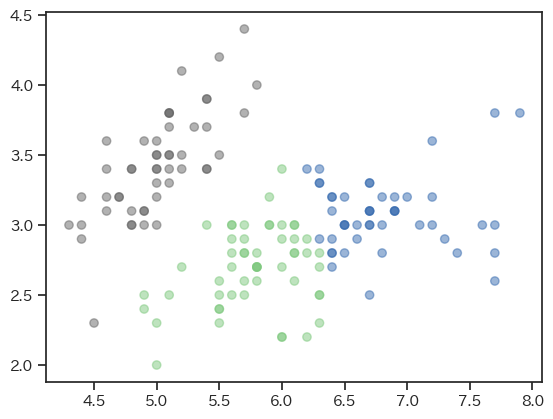

In [9]:
plt.scatter(
    iris_df.sepal_length, iris_df.sepal_width,
    c=labels,  # クラスタに応じて色分け
    cmap="Accent",
    alpha=0.5 # 点の透明度
)

では，クラスタではなく**あらかじめ分かっている3種類の品種**ごとに，散布図に色づけをしてみましょう．下記のコードを実行します．クラスタリングの結果をもとに色分けした散布図と比較してみてください．

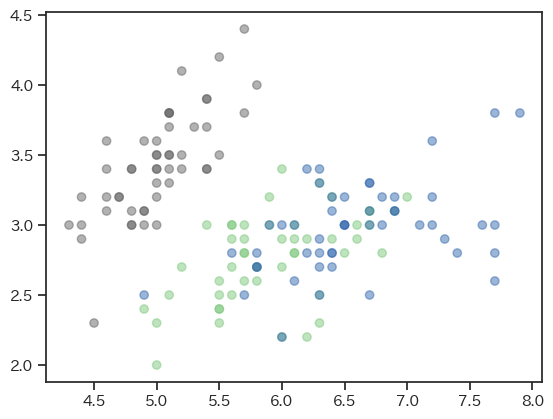

In [10]:
# 品種にIDを割り振る
species_id = {'versicolor': 0, 'virginica': 1, 'setosa': 2}

# 可視化
plt.scatter(
    iris_df.sepal_length, iris_df.sepal_width,
    c=[species_id[s] for s in iris_df.species], # もともとの品種に応じて色分け
    cmap="Accent", # カラーパレット
    alpha=0.5 # 点の透明度
)

散布図の右下で色が入り乱れています．このことから，花弁の大きさと長さだけではアヤメデータを3種類に分類することができないことが予想されます．

少し脱線しますが，アヤメデータの各指標（特徴量）の相関関係を品種ごとに表示してみましょう．
以下のコードを実行します．

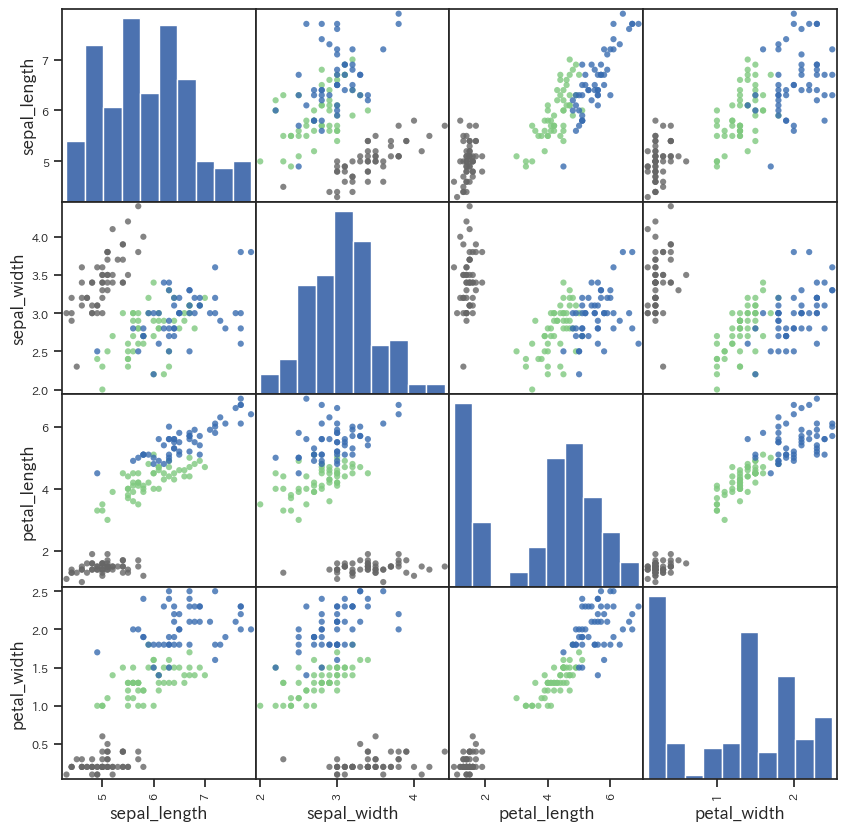

In [11]:
pd.plotting.scatter_matrix(
    iris_df,
    c=[species_id[s] for s in iris_df.species], # 品種ごとに色分け
    figsize=(10, 10), s=80, alpha=0.8, cmap="Accent" # 見た目の調整
)
plt.show()

図を眺めてみると，`petal_length`，`petal_width`の特徴も種ごとにある程度のまとまりがあるようにも見えます．そうならば，`sepal_length`，`sepal_width`の2種類だけでなく，他のすべての特徴をつかったほうがもっと高精度にグルーピングができそうです．

では，先ほどのアヤメデータのK-meansクラスタリングを，2次元ではなく4次元データにして再度実行してみましょう．
以下のコードを実行します．

In [12]:
# 注目する特徴量
target_features = ['sepal_length', 'sepal_width',
                   'petal_length', 'petal_width' # 追加項目
                  ]

# クラスタリングを実行
model = KMeans(n_clusters=3, init='random')
model.fit(iris_df[target_features])

labels = model.labels_

4次元データのクラスタリング結果を使って，散布図を色分けしてみましょう．
以下のコードを実行します．

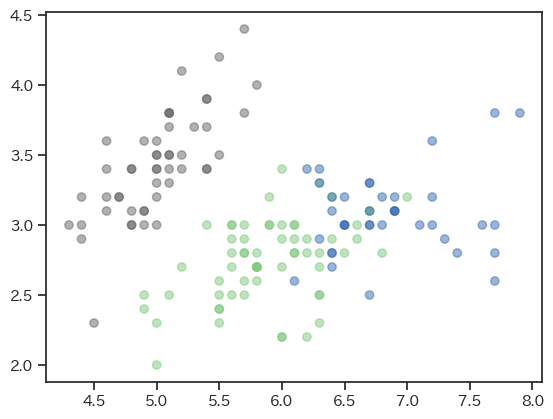

In [13]:
plt.scatter(
    iris_df.sepal_length, iris_df.sepal_width,
    c=labels,  # クラスタに応じて色分け
    cmap="Accent", alpha=0.5
)

どうでしょうか？3つの品種がより重なりなく分割されたような気がします．

---



```{attention} Q1. 類似度（1/2）（ユークリッド距離とコサイン類似度）

下2次元のユークリッド空間上に，13個のデータ点が図のように分布している状況を考える（各点の座標については，下記コードのリスト``data``に収められている）．

N次元空間上の任意の点$v_1$，$v_2$が与えられたとき，$v_1$と$v_2$のユークリッド距離を求める関数``calc_euclidean_dist(v1, v2)``，コサイン類似度を求める関数``calc_cosine_sim(v1, v2)``を実装せよ．
さらに，下図の13つの点のすべての組み合わせについて，そのユークリッド距離とコサイン類似度を求めよ．,

なお，実装する関数の第1引数および第2引数は，実数のリストを想定せよ．
```

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style('ticks')
%matplotlib inline

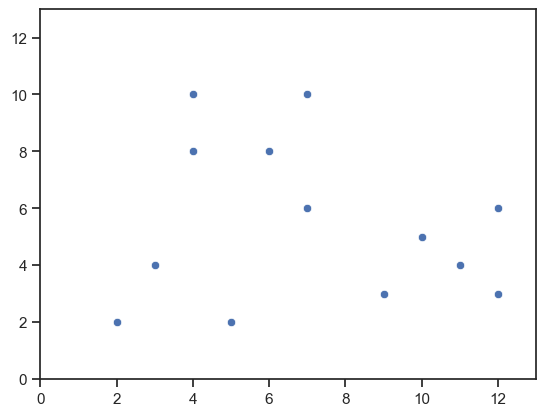

In [15]:
data = [(2, 2), (3, 4), (5, 2), (10, 5), (9, 3),
        (11, 4), (12, 3), (12, 6), (4, 10), (4, 8),
        (6, 8), (7, 10), (7, 6)]

xs, ys = zip(*data) # zipの逆操作

# 可視化
ax = sns.scatterplot(x=xs, y=ys)
ax.set_xlim(0, 13)
ax.set_ylim(0, 13)
plt.show()


---


## 例題2: 人工データに対するK-meansクラスタリング

K-meansクラスタリングの効果，特徴をもっと知るために，別のデータを分析してみましょう．

次に用いるデータは人工的に作られた5000個の2次元データです．データに特に意味はありません．
用いるデータは[University of Eastern Finlandの計算学部が公開しているデータセット](http://cs.joensuu.fi/sipu/datasets/)です．

以下のコードを実行して，``s1_df``変数にデータを読み込んでください．

In [16]:
url = "http://cs.joensuu.fi/sipu/datasets/s1.txt"
s1_df = pd.read_table(url, sep="\s+", header=None, names=['x', 'y'])

# 最初の10件のデータを表示
s1_df.head(10)

,x,y
0,664159,550946
1,665845,557965
2,597173,575538
3,618600,551446
4,635690,608046
5,588100,557588
6,582015,546191
7,604678,574577
8,572029,518313
9,604737,574591


データの傾向を見るために，XY平面にデータをプロットしてみましょう．
下記のコードを実行します．

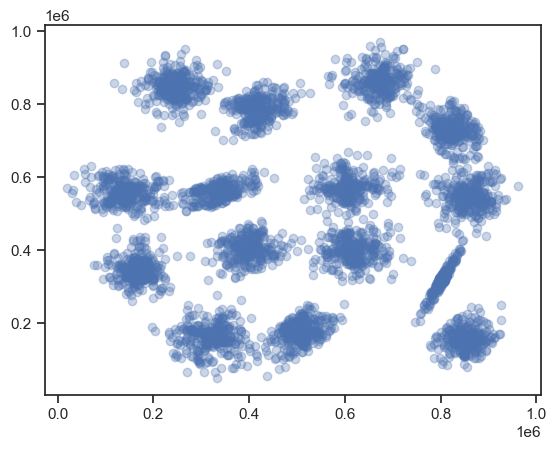

In [17]:
plt.scatter(s1_df.x, s1_df.y, alpha=0.3)
plt.show()

今回のデータの特徴は分かりやすいですね．目視レベルでは**15個**のクラスタに分かれているように見えます．

では，K-meansクラスタリングによって，目論見どおりにデータを15個のクラスタに分けられるか試してみましょう．
以下のコードを実行します．

In [18]:
# クラスタリングを実行
model = KMeans(n_clusters=15, init='random')
model.fit(s1_df)

# 結果を格納
labels = model.labels_

アヤメのデータと同様に，クラスタリングの結果を踏まえて，散布図を色分けしてみましょう．
今回はクラスタの数が15と多いので，下記のコードを実行して色分けのための準備を行います．

下記コードを実行して，散布図を15のグループごとに色分けします．
K-meansクラスタリングは，目論見どおりにデータを分割できていたでしょうか？

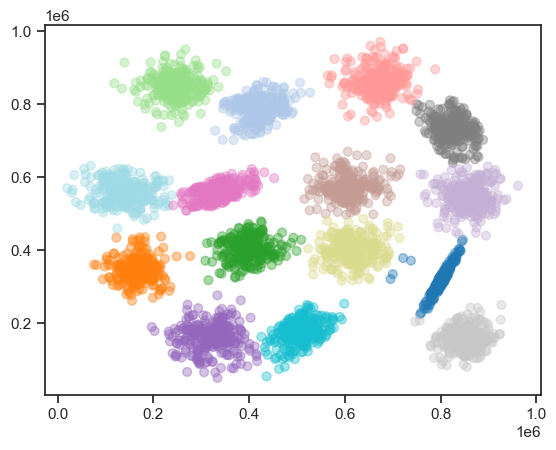

In [19]:
plt.scatter(
    s1_df.x, s1_df.y,
    c=labels,
    alpha=0.4, # 透明度
    s=40, # マーカーのサイズ
    cmap="tab20_r" # カラーパレット（20色対応）
)


---



```{attention} Q2. 類似度（2/2）（類似度の解釈）

Q1で扱ったデータ集合において，点$v=(11, 4)$との最も類似する点（最近傍点）を求めたい．ユークリッド空間の各次元の意味，最近傍点の定義が下記のような設定である場合，
点の類似性を評価する関数としてユークリッド距離，コサイン類似度のどちらを用いるのが適切か考察しながら，最近傍点を求めよ．

1. 各点は都市の位置情報を表しており，第1次元は「緯度」，第2次元は「経度」を意味する．最近傍点として，**物理的距離が近い都市**を見つけたいケース．
2. 各点はユーザの購買傾向を表しており，第1次元は「ジャンルAに属する商品を購入した回数」，第2次元は「ジャンルBに属する商品を購入した回数」を意味する．最近傍点として，**購買傾向が似ているユーザ**を見つけたいケース．
```


---


## 例題3: とある購買データに対する階層的クラスタリング

あるeコマースサイトにおける購買データを用いて階層的クラスタリングを実行してみましょう．
何も考えずに，以下のコードを実行してHands-onで用いるデータをダウンロードし，読み込みます．

In [20]:
# zipファイルをダウンロードし解凍
!wget https://gihyo.jp/assets/files/book/2014/978-4-7741-6674-2/download/DM_sampledata.zip
!unzip DM_sampledata.zip

--2023-05-08 13:28:54--  https://gihyo.jp/assets/files/book/2014/978-4-7741-6674-2/download/DM_sampledata.zip
gihyo.jp (gihyo.jp) をDNSに問いあわせています... 104.22.59.251, 104.22.58.251, 172.67.22.15
gihyo.jp (gihyo.jp)|104.22.59.251|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 41124 (40K) [application/zip]
`DM_sampledata.zip' に保存中

DM_sampledata.zip   100%[===================>]  40.16K  --.-KB/s 時間 0.005s     

2023-05-08 13:28:54 (7.61 MB/s) - `DM_sampledata.zip' へ保存完了 [41124/41124]

Archive:  DM_sampledata.zip
  inflating: DM_sampledata/ch10_hbayes.stan  
  inflating: DM_sampledata/ch3_2_2.txt  
  inflating: DM_sampledata/ch3_4_1.txt  
  inflating: DM_sampledata/ch4_3_2.txt  
  inflating: DM_sampledata/ch5_3.txt  
  inflating: DM_sampledata/ch6_4_1.txt  
  inflating: DM_sampledata/ch6_4_2.txt  
  inflating: DM_sampledata/ch7_3_2.txt  
  inflating: DM_sampledata/ch8_test.txt  
  inflating: DM_sampledata/ch8_test_label.txt  
  inflating: DM_sampledata/ch8_train.txt  
  

In [21]:
# データをpandasのデータフレームとして読み込む
e_commerce_df = pd.read_table("DM_sampledata/ch5_3.txt", header=0, sep=" ")

# ファイルを読み込んだので，元ファイル/ディレクトリを削除しておく
!rm -rf DM_sampledata.zip DM_sampledata

変数``e_commerce_df``に読み込まれたデータフレームには，
* 書籍
* 衣服
* 化粧品
* 食料品
* 飲料

を1年間で何回購入したかについて，100名の顧客のデータが記録されています（このデータは[書籍「手を動かしながら学ぶビジネスに活かすデータマイニング」のサポートページにて公開されているデータ](https://gihyo.jp/book/2014/978-4-7741-6674-2/support)です）．

以下のコードを実行し，中身を確認してみましょう．

In [22]:
# 最初の10件を表示
e_commerce_df.head()

,books,cloths,cosmetics,foods,liquors
0,43,0,3,4,10
1,25,5,5,3,11
2,19,0,2,3,8
3,31,3,3,4,5
4,46,9,2,5,7


### データ間の距離の計算

Pythonで階層的クラスタリングを実行するには`scipy`ライブラリの``linkage``関数を用いるのが簡単です．
``linkage``関数は入力（第1引数）として **ベクトル間の距離情報（を格納した行列データ）** を求めます．
ここでベクトルとは，n個の特徴量からなるデータを意味します．今回の``e_commerce_df``のデータフレームでは，1行1行が1名の顧客情報を表すベクトルデータとなります．

正攻法でやるならば，100行ある``e_commerce_df``の顧客データのすべての組み合わせを比較して，各顧客ベクトルの距離を計算する必要があります．`scipy`ライブラリはそれを簡単に実行してくれる便利な関数``distance.pdist``を提供しています．

以下のコードを実行してベクトル間の距離を計算してみましょう．

In [23]:
dist_matrix = distance.pdist(e_commerce_df, metric='euclidean')

# 距離行列を表示
pd.DataFrame(distance.squareform(dist_matrix))

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,18.841444,24.124676,13.341664,10.049876,18.708287,14.628739,41.388404,13.228757,9.486833,...,8.426150,19.442222,14.933185,35.270384,5.744563,12.124356,23.452079,18.920888,44.068129,17.378147
1,18.841444,0.000000,8.888194,9.000000,22.045408,11.789826,22.248595,25.416530,25.179357,23.302360,...,15.427249,15.968719,17.663522,49.386233,18.920888,16.431677,17.748239,9.110434,26.589472,23.216374
2,24.124676,8.888194,0.000000,12.806248,28.548205,13.416408,29.866369,25.238859,30.347982,27.856777,...,21.283797,22.583180,23.388031,56.797887,24.515301,20.024984,24.083189,12.247449,26.191602,30.033315
3,13.341664,9.000000,12.806248,0.000000,16.340135,7.071068,19.390719,29.376862,18.193405,15.556349,...,9.327379,13.564660,11.958261,44.810713,12.124356,7.937254,17.146428,7.348469,32.341923,18.654758
4,10.049876,22.045408,28.548205,16.340135,0.000000,20.856654,8.185353,39.597980,12.409674,8.426150,...,7.874008,14.525839,12.884099,28.583212,6.000000,13.190906,18.193405,19.261360,43.162484,8.888194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12.124356,16.431677,20.024984,7.937254,13.190906,9.539392,18.357560,34.146742,11.661904,9.746794,...,9.055385,14.106736,8.485281,40.484565,8.831761,0.000000,18.466185,13.228757,37.881394,15.459625
96,23.452079,17.748239,24.083189,17.146428,18.193405,18.708287,16.000000,23.811762,24.269322,22.315914,...,16.583124,5.830952,16.155494,40.570926,19.672316,18.466185,0.000000,13.928388,27.166155,12.727922
97,18.920888,9.110434,12.247449,7.348469,19.261360,10.198039,20.928450,23.216374,23.643181,20.297783,...,12.529964,11.832160,15.394804,47.138095,16.822604,13.228757,13.928388,0.000000,26.758176,19.697716
98,44.068129,26.589472,26.191602,32.341923,43.162484,30.854497,41.158231,8.185353,47.021272,45.563143,...,37.960506,29.933259,37.054015,67.216070,42.178193,37.881394,27.166155,26.758176,0.000000,39.597980


100行あるベクトルデータのすべての組み合わせについて距離を計算した結果（距離行列）が``dist_matrix``として得られました．
この距離行列を使って階層的クラスタリングを実行してみましょう．

### 階層的クラスタリングの実行

講義でも述べたように，階層的クラスタリングではクラスタの作り方の基準として
* 最長距離法（complete linkage method）
* 最短距離法（single linkage method）
* 重心法（centroid method）
* 群平均法（group average method）
* ウォード法（Ward's method）

などがあります．今回はウォード法を使ってみましょう．以下のコードを実行してみてください．

In [24]:
e_commerce_result = linkage(dist_matrix, method="ward")

階層的クラスタリングの結果が変数``e_commerce_result``に格納されました．

階層的クラスタリングにおいて，各要素（ベクトル）が徐々に併合されていく結果を示したものを**デンドログラム**と呼びます．デンドログラムを表示させてみましょう．以下のコードを実行してみてください．

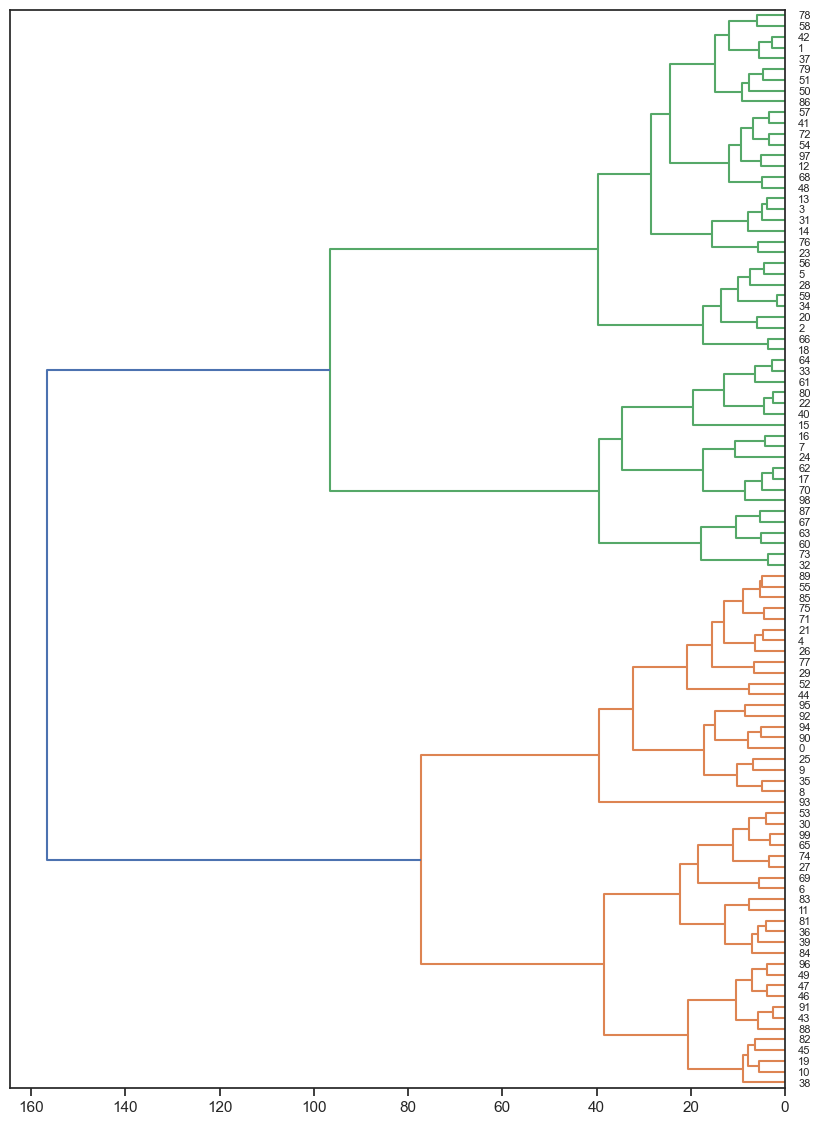

In [25]:
# 図の大きさの設定
plt.figure(figsize=(10, 14))

# 図の表示
fig = dendrogram(e_commerce_result,
                 leaf_font_size=8, orientation='left')
plt.show()

デンドログラムが表示されると，階層的クラスタリングを実行したという気分になりますね！

今回は顧客の一人一人について私たちは特に知識がないため，この図を眺めてもよく分かりません．そこで，適当な深さでデンドログラムの枝を切って，各要素をクラスタに分けてみましょう．つまりK-meansと同じようなことをします．その上で，
各クラスタに入っている要素がどのような性質を持っているかを分析していましょう．

デンドログラムの枝を切り，指定したクラスタ数に分割するには``cutree``関数を用います．``k``に数値を指定すると，デンドログラムをその数のクラスタに分割することができます．

In [26]:
# 4つのクラスタに分割
e_commerce_cluster = cut_tree(e_commerce_result, n_clusters=4)

# 最初の10件のみ表示
e_commerce_cluster[:10, 0]

array([0, 1, 1, 1, 0, 1, 2, 3, 0, 0])

変数``e_commerce_cluster``に100名の顧客のクラスタ割り当て番号が格納されました．

さて，クラスタリングの結果は変数``e_commerce_cluster``に得られましたが，各クラスタがどのような購買傾向を持っているかを分析するには，``e_commerce_df``データと照らし合わせる必要があります．
そこで，以下のコードを実行して，``e_commerce_cluster``と``e_commerce_df``を結合してみましょう．

In [27]:
# 結合
new_e_commerce_df = e_commerce_df.assign(
    cluster_id = e_commerce_cluster[:, 0]
)

# 先頭の数件のみ表示
new_e_commerce_df.head()

,books,cloths,cosmetics,foods,liquors,cluster_id
0,43,0,3,4,10,0
1,25,5,5,3,11,1
2,19,0,2,3,8,1
3,31,3,3,4,5,1
4,46,9,2,5,7,0


各顧客データがどのクラスタに分類するかのデータが得られました．このデータを用いて，クラスタ毎に書籍の平均購買数，衣類の平均購買数などを調べてみましょう．

今回の分析のように，クラスタ毎に何らかの情報をまとめて計算することを**集約演算**と呼びます．
やや複雑に見えますが，以下のコードを実行してみてください．

In [28]:
new_e_commerce_df.groupby(
    'cluster_id' # cluster_idでデータをまとめる
).agg(
    'mean' # まとまり毎に平均値を算出
)

,books,cloths,cosmetics,foods,liquors
cluster_id,,,,,
0,48.363636,8.454545,4.636364,5.636364,3.863636
1,26.562500,6.187500,4.500000,4.750000,5.531250
2,35.923077,17.730769,4.423077,5.000000,6.923077
3,9.200000,14.400000,5.350000,4.250000,8.400000


クラスタ毎に書籍，衣類，化粧品，食料品，飲料の平均購買数が求まりました．クラスタ毎に少しずつ特徴が異なることが確認できます．


---


```{attention} Q3. 階層的クラスタリング

Q1で扱った13個のデータ点について，階層的クラスタリング法を用いて段階的にクラスタに分割したい．


``scipy.cluster.hierarchy``ライブラリの``linkage``関数および``dendrogram``関数を用いて，Q1で扱ったデータに階層的クラスタリングを適用せよ．その際，階層的クラスタリングのクラスタ生成手法として下記3つの方法を用いて，クラスタの生成過程を結果を比較せよ：

* セントロイド法（centroid）
* 最短距離法（single linkage）
* 最長距離法（complete linkage）

なお，クラスタ間の距離の尺度にはユークリッド距離を用いること．
```


---


## 例題4: 2018年度プロ野球打者成績データに対する階層的クラスタリング


例題3のデータは見ず知らずの顧客のデータであったため，クラスタリングをしても予想される結果がイメージしにくかったと思います．そこで次は実データを分析してみましょう．
下記コマンドを実行して，Hands-onで用いるデータを読み込みます． このデータは2018年度のプロ野球において，規定打席に達した打者の成績（例：「打率」「出塁率」「長打率」）を記録したものです．

※ 本データは，過去に講師が[日本プロ野球機構の公式サイト](https://npb.jp/)から手作業で取得したものです．

In [30]:
# データの読み込み
url = "https://raw.githubusercontent.com/hontolab-courses/dmml-2023/main/dataset/baseball_stats_2018.tsv"
stats_df = pd.read_table(url, header=0, sep="\t", index_col='選手名')

# 最初の数件を表示
stats_df.head()

EmptyDataError: No columns to parse from file

このデータに対して，階層的クラスタリングを実行して傾向が似通った選手をグルーピングしてみましょう．

データをご覧になると分かるように，``stats_df``には「打率」「安打数」「ホームラン数」といった成績情報以外に「チーム名」（とデータのラベルとして「選手名」）が含まれています．
今回の分析では野手成績に関係する「打率」〜「長打率」だけに焦点をしぼって分析をします．

``stats_df``では「打率」〜「長打率」は1〜17列目（0列スタート）に格納されています．
``stats_df``から1〜17列目だけを抜き出すには，下記のようなコードを書きます．

In [ ]:
stats_df.iloc[:, 1:17]

この方法を使って，選手データをクラスタリングしてみましょう．

例題3と同様，今回の分析では階層的クラスタリングのタイプとして**ウォード法**を用いることにします．
下記のコードを実行すると，階層的クラスタリングを行い，その結果をデンドログラムとして表示します．

In [ ]:
# 距離行列の計算
stats_dist_matrix = distance.pdist(stats_df.iloc[:, 1:17], metric='euclidean')

# 階層的クラスタリングの実行
stats_result = linkage(stats_dist_matrix, method="ward")

# デンドログラムの表示
plt.figure(figsize=(10, 10))
fig = dendrogram(stats_result, labels=stats_df.index, 
                leaf_font_size=9, orientation='left')
plt.show()

デンドログラムが表示されました．プロ野球に関心のある方からご覧になって，このクラスタリング結果は妥当なものでしょうか？

例題3と同様に，各クラスタの平均的なスコアを計算してみましょう．
図を見ると，今回の結果から，データはざっくり見ると6クラスタに分かれそうです．
とりあえず6クラスタに分けたときに，各クラスタの平均スコアがどうなっているかを分析してみましょう．

In [ ]:
# 6つのクラスタに分割
stats_cluster = cut_tree(stats_result, n_clusters=6)

# クラスタ情報と選手データを結合
new_stats_df = stats_df.assign(
    cluster_id = stats_cluster[:, 0]
)

# 各クラスタの平均スコアを計算
new_stats_df.groupby(
    'cluster_id' # cluster_idでデータをまとめる
).agg(
    'mean' # まとまり毎に平均値を算出
)

各クラスタの特徴は以下のような感じでしょうか：
* 第1クラスタ: 打率も高く，ホームランも盗塁もできるユーティリティプレーヤー
* 第2クラスタ: ホームランヒッター
* 第3クラスタ: 打率もホームランもそこそこ高い6番バッタータイプ
* 第4クラスタ: これといって特徴はない
* 第5クラスタ: 出塁率が高く盗塁も多く足が速い，リードオフ・マンタイプ
* 第6クラスタ: 打率は高くないが，堅実に犠打でランナーを進める，2番バッタータイプ